<a href="https://colab.research.google.com/github/Generative-AI-in-Computer-Vision/generative-ai-in-computer-vision/blob/main/chapter-02/Ch02_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2: Variational Autoencoder (VAE)

## Step 1: Import Necessary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Step 2: Prepare the Dataset

In [ ]:
batch_size = 32

# Transformations
transform = transforms.ToTensor()

# Download and load the training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5805392.23it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 153989.71it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1447055.66it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3238233.68it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Step 3: Implement the Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

    def forward(self, x):
        h = self.conv_layers(x)
        h = F.relu(self.fc1(h))
        return self.fc_mu(h), self.fc_logvar(h)

## Step 4: Implement the Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7))
        )
        self.convtranspose_layers = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        h = self.fc(z)
        return self.convtranspose_layers(h)

## Step 5: Implement the VAE Model

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

## Step 6: Define the VAE Loss Function

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

## Step 7: Initialize the Model and Optimizer

In [ ]:
latent_dim = 50

model = VAE(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Step 8: Train the VAE

In [ ]:
num_epochs = 30

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img)
        loss = vae_loss(recon_batch, img, mu, logvar)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()/len(img):.4f}')

Epoch [1/30], Loss: 128.5971
Epoch [2/30], Loss: 106.1571
Epoch [3/30], Loss: 104.5631
Epoch [4/30], Loss: 117.5329
Epoch [5/30], Loss: 111.4008
Epoch [6/30], Loss: 103.1936
Epoch [7/30], Loss: 103.8095
Epoch [8/30], Loss: 103.8640
Epoch [9/30], Loss: 92.4726
Epoch [10/30], Loss: 113.2838
Epoch [11/30], Loss: 103.2243
Epoch [12/30], Loss: 100.7592
Epoch [13/30], Loss: 99.5044
Epoch [14/30], Loss: 106.5931
Epoch [15/30], Loss: 103.3110
Epoch [16/30], Loss: 101.9742
Epoch [17/30], Loss: 100.2633
Epoch [18/30], Loss: 91.7983
Epoch [19/30], Loss: 97.0320
Epoch [20/30], Loss: 100.5534
Epoch [21/30], Loss: 104.2018
Epoch [22/30], Loss: 97.9585
Epoch [23/30], Loss: 97.9891
Epoch [24/30], Loss: 98.8250
Epoch [25/30], Loss: 99.7847
Epoch [26/30], Loss: 95.2029
Epoch [27/30], Loss: 95.4581
Epoch [28/30], Loss: 98.1498
Epoch [29/30], Loss: 96.4821
Epoch [30/30], Loss: 99.1380


## Step 9: Model Evaluation

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    # Generate points in the latent space
    z_input = torch.randn(n_samples, latent_dim)
    return z_input

def generate_images(n_samples, model, latent_dim):
    # Sample random points in the latent space
    z_input = generate_latent_points(latent_dim, n_samples)

    # Generate images from these latent points
    model.eval()
    with torch.no_grad():
        # Move the latent vector to the same device as the model
        z_input = z_input.to(next(model.parameters()).device)
        # images = model.decode(z_input)
        images = model.decoder(z_input)

    return images

In [ ]:
def interpolate_latent_points(start, end, n_steps=10):
    # Linear interpolation
    ratios = torch.linspace(0, 1, steps=n_steps).unsqueeze(1)
    return start + ratios * (end - start)

def interpolate_and_generate_images(model, latent_dim, n_steps=10):
    # Generate start and end points in the latent space
    start = generate_latent_points(latent_dim, 1)
    end = generate_latent_points(latent_dim, 1)

    # Interpolate between these two points
    interpolated_points = interpolate_latent_points(start, end, n_steps)

    # Generate images
    model.eval()
    with torch.no_grad():
        # Move the latent vector to the same device as the model
        interpolated_points = interpolated_points.to(next(model.parameters()).device)
        images = model.decoder(interpolated_points)

    return images

In [ ]:
def show_images(images, n_samples):
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        ax = plt.subplot(1, n_samples, i+1)
        plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

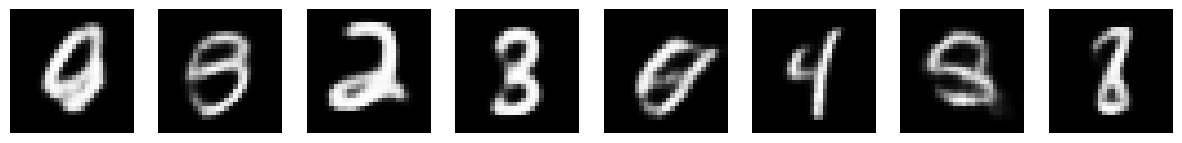

In [ ]:
# Generate and display images
n_samples = 8  # Number of images to generate
generated_images = generate_images(n_samples, model, latent_dim)
show_images(generated_images, n_samples)

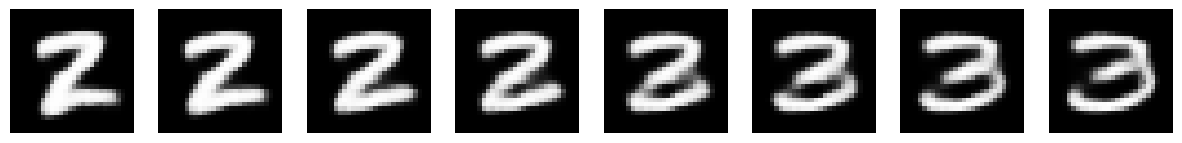

In [ ]:
n_steps = 8  # Number of interpolation steps/images
interpolated_images = interpolate_and_generate_images(model, latent_dim, n_steps)
show_images(interpolated_images, n_steps)